In [1]:
!pip install fasttext

     |████████████████████████████████| 71kB 5.7MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3093821 sha256=8643ddc9182dc2a8d63da82614cbf9d459f0ac1c363f711bc92a702eb26b2e0a
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import fasttext.util
#fasttext.util.download_model('ko', if_exists='ignore')

In [3]:
# library 
import tensorflow as tf
import numpy as np
import fasttext
import numpy as np
from tqdm import tqdm
import math
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Embedding 

In [4]:
EMBEDDING_DIM = 300   # fasttext 임베딩 차원 

# 함수 두개 합침 
def drop_token(x):
    sw = ['부대사업','사업','부대','각호','판매업', '한다', '거나', '에게']   # 불용어 제거 
    x = [word for word in x if not word in sw]

    if len(x)>50:   # drop (100개는 파라미터로 튜닝 가능)
      return x[:50]
    else:
      return x  # 중복 제거해봄 >> 이게 되게 안좋은가봐
 

# X, y train data 만들기 
def read_corpus(path):
    data = pd.read_pickle(path)
    data = data.query('big not in ["O","U","T"]')  # 나중에 out 얘네들 rule base로 쳐내야함 

    ## 이걸로 수정함 
    X = [x for x in data.iloc[:,-1].apply(drop_token)] 
    Y = pd.get_dummies(data['big']).values   # 대분류 get dummy로 펼치기 

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,
                                                    random_state=1214,
                                                    stratify=Y)
  
    # valid set 추가
    tr_x, val_x, tr_y, val_y = train_test_split(Xtrain, Ytrain, test_size=0.2,
                                                    random_state=1230,
                                                    stratify=Ytrain)

    #label_enc = OneHotEncoder()    
    #Ytrain_p = label_enc.fit_transform(np.array(Ytrain).reshape(-1,1))
    #Ytest_p = label_enc.transform(np.array(Ytest).reshape(-1,1))    
    return np.array(tr_x), np.array(Xtest), np.array(tr_y), np.array(Ytest), np.array(val_x), np.array(val_y)  # array 로 반환 


## max_len 제한 둔 패딩 
def pad(data, max_len=50):    
    if max_len == 0:
        max_len = max(len(tokens) for tokens in data)

    result = []
    for tokens in tqdm(data, desc='Padding'):
        if len(tokens) >= max_len:  ## max_len보다 크면 그냥 max_len까지만 자르기 
            result.append(tokens[:max_len])

        else:
            n_to_pad = max_len - len(tokens) 
            result.append(tokens + [''] * n_to_pad)

    return max_len, result


## 패딩하기 
def preprocess(tokenized_sentences):
    max_tokens, padded_sentences = pad(tokenized_sentences)
    return padded_sentences

### Sequence dataset 맞춤형 딥러닝 
class Dataset(tf.keras.utils.Sequence):
    fasttext_model_cache = {}
    
    def __init__(self, x_set, y_set, batch_size):
        self.x_set = x_set
        self.y_set = y_set
        self.batch_size = batch_size

        fasttext_model_path = '/content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/cc.ko.300.bin' # 나중에 추가학습 시도하기 

        if fasttext_model_path not in Dataset.fasttext_model_cache:
            Dataset.fasttext_model_cache[fasttext_model_path] = fasttext.load_model(fasttext_model_path)  

        self.fasttext_model = Dataset.fasttext_model_cache[fasttext_model_path]
        #self.fasttext_model = fasttext.load_model(fasttext_model_path)

    def __len__(self):
        return math.ceil(len(self.x_set) / self.batch_size)   # ceil : 올림 

    def __getitem__(self, idx):
        padded_sentences = self.x_set[idx * self.batch_size:(idx + 1) * self.batch_size]  
              
        word_vectors = [self.get_word_vectors(padded_sentence) for padded_sentence in padded_sentences]        
        batch_y = self.y_set[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return np.array(word_vectors), np.array(batch_y)
    
    ## word_vectors를 얻기 
    def get_word_vectors(self, words):
        result = []
        for word in words:
            if not word: 
                result.append(np.zeros((EMBEDDING_DIM,)))   # LSTM을 위한 zero padding 
            else:
                result.append(self.fasttext_model.get_word_vector(word))

        return np.array(result)

In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/data/final_data/0504_alltoken.pkl'
batch_size =  128

#### X, y data 만들기 (train 내에서 split 한거임) + valid split까지 
train_sentences, test_sentences, train_labels, test_labels, valid_sentences, valid_labels = read_corpus(path)


#### train 
train_padded_sentences = preprocess(train_sentences)   # 패딩하기 
train_dataset = Dataset(train_padded_sentences, train_labels, batch_size)    # Dataset 제작 

### valid 
valid_padded_sentences = preprocess(valid_sentences)   # 패딩하기 
valid_dataset = Dataset(valid_padded_sentences, valid_labels, batch_size)    # Dataset 제작

### test 
test_padded_sentences = preprocess(test_sentences)       
test_batch_size = batch_size   # train과 동일하게 설정 
test_dataset = Dataset(test_padded_sentences, test_labels, test_batch_size)    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Padding: 100%|██████████| 315743/315743 [00:04<00:00, 71986.09it/s] 


valid 어떠카지...

## Modeling

In [12]:
## Modeling function 
# def build_model():
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True), 
#                                             input_shape=(None, EMBEDDING_DIM)))
#     model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)))
#     model.add(tf.keras.layers.Dense(64))
#     model.add(tf.keras.layers.Dense(17, activation='softmax'))    ## 17개의 대분류 분류
#     model.summary() 

#     return model


# ### dense로 바꿔보기 
# def build_model():
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True), input_shape=(None, EMBEDDING_DIM)))
#     # model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))

#     model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)))

#     ## dense 추가
#     # model.add(tf.keras.layers.Dense(500, kernel_initializer= 'he_normal', activation='relu'))
#     # model.add(tf.keras.layers.Dropout(0.3))

#     model.add(tf.keras.layers.Dense(100, kernel_initializer= 'he_normal', activation='relu'))
#     # model.add(tf.keras.layers.Dropout(0.5))
#     model.add(tf.keras.layers.Dropout(0.3))

#     # model.add(tf.keras.layers.Dense(50, kernel_initializer= 'he_normal', activation='relu'))
#     # # model.add(tf.keras.layers.Dropout(0.5))

#     model.add(tf.keras.layers.Dense(17, activation='softmax'))    ## 17개의 대분류 분류
#     model.summary() 

#     return model

## 1d conv 
def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True), input_shape=(None, EMBEDDING_DIM)))
    # model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))

    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)))

    ## dense 추가
    # model.add(tf.keras.layers.Dense(500, kernel_initializer= 'he_normal', activation='relu'))
    # model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(100, kernel_initializer= 'he_normal', activation='relu'))
    # model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dropout(0.3))

    # model.add(tf.keras.layers.Dense(50, kernel_initializer= 'he_normal', activation='relu'))
    # # model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(17, activation='softmax'))    ## 17개의 대분류 분류
    return model

#     return model
# from keras.models import Model
# from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
# from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
# from keras.preprocessing import text, sequence
# from keras.callbacks import Callback

# def build_model():
#     inp = Input(shape=(None,EMBEDDING_DIM))
#     x = Bidirectional(GRU(256, return_sequences=True))(inp)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     outp = Dense(17, activation="softmax")(conc)

#     model = Model(inputs=inp, outputs=outp)
#     model.summary()

#     return model 


In [13]:
model = build_model()   
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, None, 256)         439296    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_6 (Dense)              (None, 100)               25700     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 17)                1717      
Total params: 860,953
Trainable params: 860,953
Non-trainable params: 0
_________________________________________________________________


In [14]:
batch_size =  128
epoch = 10

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
history = model.fit(train_dataset, epochs=epoch, validation_data=valid_dataset)  

## 50개일 때는 1 epoch에 7분정도(대폭 감소) 근데 성능은 유지중

Epoch 1/10
7894/7894 [==============================] - 492s 60ms/step - loss: 0.7876 - accuracy: 0.7691 - val_loss: 0.5652 - val_accuracy: 0.8280
Epoch 2/10
7894/7894 [==============================] - 480s 61ms/step - loss: 0.5646 - accuracy: 0.8318 - val_loss: 0.5341 - val_accuracy: 0.8355
Epoch 3/10
7894/7894 [==============================] - 469s 59ms/step - loss: 0.5316 - accuracy: 0.8389 - val_loss: 0.5273 - val_accuracy: 0.8383
Epoch 4/10
7894/7894 [==============================] - 466s 59ms/step - loss: 0.5076 - accuracy: 0.8446 - val_loss: 0.5219 - val_accuracy: 0.8392
Epoch 5/10
7894/7894 [==============================] - 457s 58ms/step - loss: 0.4916 - accuracy: 0.8479 - val_loss: 0.5205 - val_accuracy: 0.8408
Epoch 6/10
7894/7894 [==============================] - 456s 58ms/step - loss: 0.4693 - accuracy: 0.8536 - val_loss: 0.5228 - val_accuracy: 0.8408
Epoch 7/10
7894/7894 [==============================] - 457s 58ms/step - loss: 0.4498 - accuracy: 0.8579 - val_loss: 0

In [13]:
batch_size =  128
epoch = 10

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
history = model.fit(train_dataset, epochs=epoch, validation_data=valid_dataset)  

## 50개일 때는 1 epoch에 7분정도(대폭 감소) 근데 성능은 유지중

Epoch 1/10
7894/7894 [==============================] - 414s 50ms/step - loss: 0.7166 - accuracy: 0.7826 - val_loss: 0.5492 - val_accuracy: 0.8320
Epoch 2/10
7894/7894 [==============================] - 389s 49ms/step - loss: 0.5285 - accuracy: 0.8362 - val_loss: 0.5490 - val_accuracy: 0.8282
Epoch 3/10
7894/7894 [==============================] - 393s 50ms/step - loss: 0.5005 - accuracy: 0.8439 - val_loss: 0.5267 - val_accuracy: 0.8366
Epoch 4/10
7894/7894 [==============================] - 398s 50ms/step - loss: 0.4773 - accuracy: 0.8496 - val_loss: 0.5273 - val_accuracy: 0.8388
Epoch 5/10
7894/7894 [==============================] - 391s 49ms/step - loss: 0.4555 - accuracy: 0.8559 - val_loss: 0.5280 - val_accuracy: 0.8395
Epoch 6/10
7894/7894 [==============================] - 396s 50ms/step - loss: 0.4335 - accuracy: 0.8618 - val_loss: 0.5437 - val_accuracy: 0.8369
Epoch 7/10
7894/7894 [==============================] - 390s 49ms/step - loss: 0.4118 - accuracy: 0.8686 - val_loss: 0

In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset)    
print('test_loss', test_loss)
print('test_accuracy', test_accuracy)   # 샘플링 안한 bilstm + dense

2467/2467 [==============================] - 107s 43ms/step - loss: 0.5688 - accuracy: 0.8383
test_loss 0.5688146948814392
test_accuracy 0.8383147120475769


In [14]:
test_loss, test_accuracy = model.evaluate(test_dataset)    
print('test_loss', test_loss)
print('test_accuracy', test_accuracy)   # 샘플링 안한 gru + pooling

2467/2467 [==============================] - 97s 39ms/step - loss: 0.5904 - accuracy: 0.8313
test_loss 0.590385913848877
test_accuracy 0.8312583565711975


In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)    
print('test_loss', test_loss)
print('test_accuracy', test_accuracy)   # token 50 >> 여전히 오버피팅. 토큰은 50으로 유지하는게 좋은듯

2467/2467 [==============================] - 90s 36ms/step - loss: 0.5628 - accuracy: 0.8398
test_loss 0.562758207321167
test_accuracy 0.8397969007492065


In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)    
print('test_loss', test_loss)
print('test_accuracy', test_accuracy)   # 3 dense + token100
## lstm128 + dense500(0.8), dense100, 50(0.5)  

2467/2467 [==============================] - 179s 72ms/step - loss: 0.5920 - accuracy: 0.8383
test_loss 0.591994047164917
test_accuracy 0.8382766842842102


In [16]:
# model.save('./model/classfier.{}.model'.format('fasttext'))
model.save('/content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/model/classfier.fasttext.model/lstm_nonsample0514')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/model/classfier.fasttext.model/lstm_nonsample0514/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/model/classfier.fasttext.model/lstm_nonsample0514/assets


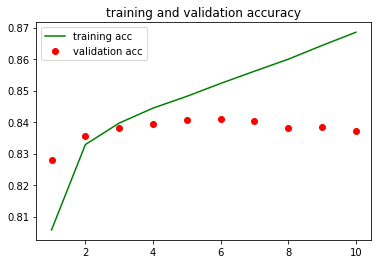

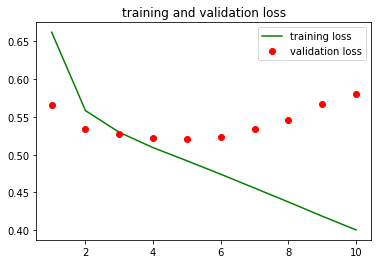

In [17]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'g',label='training acc')
plt.plot(epochs,val_acc,'ro',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'g',label='training loss')
plt.plot(epochs,val_loss,'ro',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

## Confusion Matrix

In [18]:
data = pd.read_pickle(path)
data = data.query('big not in ["O","U","T"]')  

In [20]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(test_dataset)
labeled_ypred = np.argmax(y_pred,axis=1)
labeled_ytrue = np.where(test_labels==1)[1]

colnrow=sorted(data.big.unique())
cm = pd.DataFrame(confusion_matrix(labeled_ytrue,labeled_ypred),columns=colnrow,index=colnrow) #true X pred

In [21]:
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(labeled_ytrue,labeled_ypred),columns=colnrow,index=colnrow) #true X pred

In [22]:
cm   # lstm

,A,C,D,E,F,G,H,I,J,K,L,M,N,P,Q,R,S
A,13998,189,8,2,55,325,11,7,8,2,21,52,16,8,8,19,181
C,240,57260,84,326,1202,3301,89,102,914,49,181,756,444,20,6,28,88
D,16,85,3730,11,186,49,1,1,6,2,26,57,6,0,0,0,24
E,6,279,11,1857,123,165,23,0,30,11,21,122,112,2,1,1,8
F,84,1420,164,61,30427,659,63,25,141,9,796,557,553,12,10,37,48
G,1648,7644,47,222,1089,52416,288,193,1144,92,395,799,460,96,40,91,386
H,29,122,4,29,84,269,8397,5,26,5,69,50,375,8,1,8,79
I,7,238,2,0,27,191,8,3364,28,8,93,173,105,9,3,48,14
J,3,702,4,6,156,673,31,10,19091,89,113,505,256,179,6,46,41
K,1,59,6,5,19,87,6,6,100,10684,106,163,122,9,2,4,11


In [26]:
cm.to_csv('/content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/data/confusion_matrix0514.csv', index=False)

In [35]:
# class 별 오분류율
err = pd.DataFrame(cm.max(axis=1)/cm.sum(axis=1), columns=['정분류율']).reset_index().sort_values(by='정분류율').reset_index(drop=True)

In [36]:
err

,index,정분류율
0,R,0.655468
1,E,0.669913
2,M,0.767720
3,P,0.770613
4,I,0.779064
5,G,0.781745
6,N,0.794792
7,Q,0.798988
8,S,0.802306
9,L,0.853031


In [21]:
cm   # gru

,A,C,D,E,F,G,H,I,J,K,L,M,N,P,Q,R,S
A,13824,251,13,2,90,363,21,8,7,3,12,32,10,10,6,22,236
C,212,56518,77,216,1296,4064,118,145,1010,64,159,723,321,18,11,29,109
D,9,92,3737,11,187,45,6,1,9,4,20,54,3,0,0,0,22
E,9,356,12,1753,119,193,33,1,35,18,16,118,98,1,0,2,8
F,73,1501,199,64,30683,677,112,30,160,13,583,434,426,3,11,42,55
G,1583,7494,51,181,1181,52192,470,215,1341,99,371,723,415,74,42,114,504
H,26,106,3,22,85,217,8620,3,20,6,53,38,267,7,5,12,70
I,6,213,1,3,38,199,9,3461,22,10,78,130,59,6,4,58,21
J,2,712,5,10,167,654,52,18,19226,97,105,399,232,111,6,66,49
K,3,62,6,7,22,75,8,13,128,10728,98,136,84,5,1,5,9


In [22]:
# class 별 오분류율
cm.max(axis=1)/cm.sum(axis=1)

A    0.927163
C    0.868305
D    0.889762
E    0.632395
F    0.875007
G    0.778404
H    0.901674
I    0.801528
J    0.877459
K    0.941879
L    0.833049
M    0.733289
N    0.756694
P    0.687935
Q    0.783809
R    0.685979
S    0.830121
dtype: float64